## Accessing US Census data with the Planetary Computer STAC API

The [US Census](https://planetarycomputer.microsoft.com/dataset/us-census) collection provides information on population, demographics, and administrative boundaries at various levels of cartographic aggregation for the United States. It consists of many tabular datasets, one for each level of cartographic aggregation, each stored in [Apache Parquet](https://parquet.apache.org/) format. In this notebook, we'll use [geopandas](https://geopandas.org/) and dask-geopandas to read the files, which will preserve the `geometry` column with administrative boundaries.

In [1]:
import geopandas
import dask_geopandas
import contextily as ctx
import seaborn as sns
import planetary_computer
import pystac_client

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Each item in the `us-census` collection represents a single table, aggregating the census data a some level (Congressional district, state, etc.).

In [3]:
search = catalog.search(collections=["us-census"])
items = {item.id: item for item in search.items()}
list(items)

['2020-census-blocks-population',
 '2020-census-blocks-geo',
 '2020-cb_2020_us_vtd_500k',
 '2020-cb_2020_us_unsd_500k',
 '2020-cb_2020_us_ttract_500k',
 '2020-cb_2020_us_tract_500k',
 '2020-cb_2020_us_tbg_500k',
 '2020-cb_2020_us_state_500k',
 '2020-cb_2020_us_sldu_500k',
 '2020-cb_2020_us_sldl_500k',
 '2020-cb_2020_us_scsd_500k',
 '2020-cb_2020_us_region_500k',
 '2020-cb_2020_us_place_500k',
 '2020-cb_2020_us_nectadiv_500k',
 '2020-cb_2020_us_necta_500k',
 '2020-cb_2020_us_nation_5m',
 '2020-cb_2020_us_metdiv_500k',
 '2020-cb_2020_us_elsd_500k',
 '2020-cb_2020_us_division_500k',
 '2020-cb_2020_us_csa_500k',
 '2020-cb_2020_us_cousub_500k',
 '2020-cb_2020_us_county_within_cd116_500k',
 '2020-cb_2020_us_county_500k',
 '2020-cb_2020_us_concity_500k',
 '2020-cb_2020_us_cnecta_500k',
 '2020-cb_2020_us_cd116_500k',
 '2020-cb_2020_us_cbsa_500k',
 '2020-cb_2020_us_bg_500k',
 '2020-cb_2020_us_aitsn_500k',
 '2020-cb_2020_us_aiannh_500k',
 '2020-cb_2020_72_subbarrio_500k',
 '2020-cb_2020_02_anrc_

### Read Congressional districts

The `2020-cb_2020_us_cd116_500k` dataset contains geometries for Congressional Districts for the 166th Congress.

In [4]:
item = items["2020-cb_2020_us_cd116_500k"]
item

id: 2020-cb_2020_us_cd116_500k
"bbox: [-179.148909, -14.548699, 179.77847, 71.365162]"
datetime: 2021-08-01T00:00:00Z
proj:epsg: 4269
"table:columns: [{'name': 'STATEFP', 'type': 'byte_array', 'description': 'State FIPS Code'}, {'name': 'CD116FP', 'type': 'int64', 'description': 'Congressional District FIPS code'}, {'name': 'AFFGEOID', 'type': 'byte_array', 'description': 'American FactFinder summary level code + geovariant code + ""00US"" + GEOID'}, {'name': 'GEOID', 'type': 'byte_array', 'description': 'Concatenation of State FIPS and congressional district FIPS code'}, {'name': 'NAMELSAD', 'type': 'byte_array', 'description': 'Legal/statistical description and name'}, {'name': 'LSAD', 'type': 'byte_array', 'description': 'Legal/statistical classification'}, {'name': 'CDSESSN', 'type': 'int64', 'description': 'Congressional Session Code'}, {'name': 'ALAND', 'type': 'int64', 'description': 'Current land area'}, {'name': 'AWATER', 'type': 'int64', 'description': 'Current water area'}, {'name': 'geometry', 'type': 'byte_array', 'description': 'coordinates for Congressional District polygons'}]"
table:row_count: 441
https://stac-extensions.github.io/table/v1.2.0/schema.json
https://stac-extensions.github.io/projection/v1.0.0/schema.json
href: abfs://us-census/2020/cb_2020_us_cd116_500k.parquet
type: application/x-parquet
title: Dataset root


Each of the items contains a single asset, `data`, that has all the URL to the Parquet dataset and all the information necessary to load it.

In [5]:
asset = item.assets["data"]
asset

href: abfs://us-census/2020/cb_2020_us_cd116_500k.parquet
type: application/x-parquet
title: Dataset root
roles: ['data']
owner: 2020-cb_2020_us_cd116_500k
"table:storage_options: {'account_name': 'ai4edataeuwest', 'credential': 'st=2023-11-06T12%3A44%3A44Z&se=2023-11-14T12%3A44%3A44Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-11-07T12%3A44%3A43Z&ske=2023-11-14T12%3A44%3A43Z&sks=b&skv=2021-06-08&sig=NIL04eXZ%2BA8ere9/0RqCb4epsrioMveLEKcPOz2/104%3D'}"


This is an [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) URL, which is used by libraries like pandas, geopandas, and Dask to work with files from remote storage like Azure Blob Storage. We already signed this asset to include a `credential`. If you use an unsigned asset you'll see a `ClientAuthenticationError` error when trying to open the dataset

In [6]:
df = geopandas.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
)
df.head()

,STATEFP,CD116FP,AFFGEOID,GEOID,NAMELSAD,LSAD,CDSESSN,ALAND,AWATER,geometry
0,06,42,5001600US0642,0642,Congressional District 42,C2,116,2424753563,44105315,"POLYGON ((-117.67629 33.88882, -117.65488 33.8..."
1,39,7,5001600US3907,3907,Congressional District 7,C2,116,10010016396,64562455,"MULTIPOLYGON (((-82.55933 40.78975, -82.55835 ..."
2,48,3,5001600US4803,4803,Congressional District 3,C2,116,1245574011,97890112,"POLYGON ((-96.84410 32.98891, -96.84403 32.992..."
3,28,2,5001600US2802,2802,Congressional District 2,C2,116,40278711117,951654563,"POLYGON ((-91.36371 31.78036, -91.35951 31.799..."
4,42,18,5001600US4218,4218,Congressional District 18,C2,116,757655195,19985421,"POLYGON ((-80.17834 40.33725, -80.17537 40.338..."


We'll select a single district (Maryland's 2nd) and plot it.

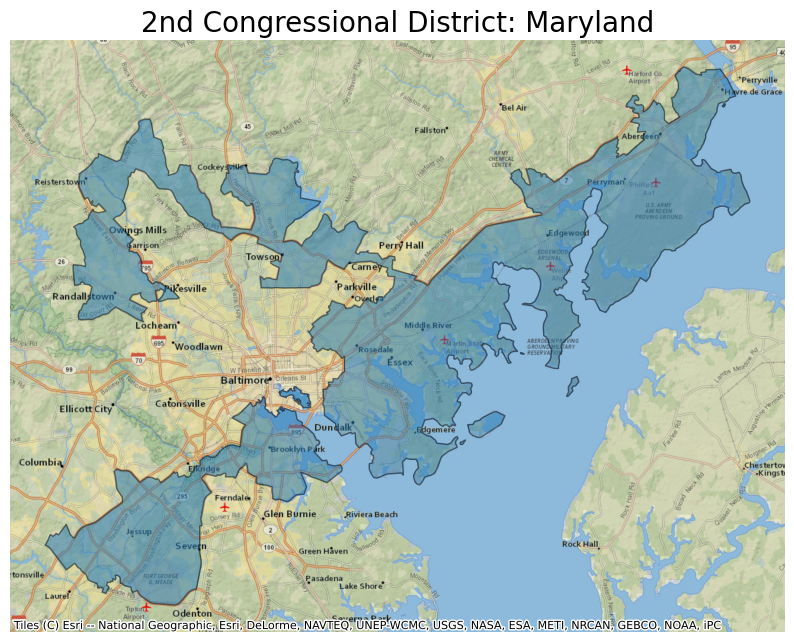

In [7]:
ax = (
    df[df.GEOID == "2402"]
    .to_crs(epsg=3857)
    .plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
)
ax.set_title(
    "2nd Congressional District: Maryland",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)
ax.set_axis_off()

### Read Census Block data

Census blocks are the smallest cartographic unit available from the Census Bureau. There are over 8 million census blocks.

In [8]:
geo = dask_geopandas.read_parquet(
    "abfs://us-census/2020/census_blocks_geo.parquet",
    storage_options=asset.extra_fields["table:storage_options"],
    calculate_divisions=True,
)
geo

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
npartitions=56,,,,,,,,,
010010201001000,category[unknown],category[unknown],int64,int64,int64,int64,float64,float64,geometry
020130001001000,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
780109701001000,...,...,...,...,...,...,...,...,...
780309900000008,...,...,...,...,...,...,...,...,...


In [9]:
import dask.dataframe

pop = dask.dataframe.read_parquet(
    "abfs://us-census/2020/census_blocks_population.parquet",
    storage_options=asset.extra_fields["table:storage_options"],
    calculate_divisions=True,
)
pop

,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,P0010008,P0010009,P0010010,P0010011,P0010012,P0010013,P0010014,P0010015,P0010016,P0010017,P0010018,P0010019,P0010020,P0010021,P0010022,P0010023,P0010024,P0010025,P0010026,P0010027,P0010028,P0010029,P0010030,P0010031,P0010032,P0010033,P0010034,P0010035,P0010036,P0010037,P0010038,P0010039,P0010040,P0010041,P0010042,P0010043,P0010044,P0010045,P0010046,P0010047,P0010048,P0010049,P0010050,P0010051,P0010052,P0010053,P0010054,P0010055,P0010056,P0010057,P0010058,P0010059,P0010060,P0010061,P0010062,P0010063,P0010064,P0010065,P0010066,P0010067,P0010068,P0010069,P0010070,P0010071,P0020001,P0020002,P0020003,P0020004,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0020012,P0020013,P0020014,P0020015,P0020016,P0020017,P0020018,P0020019,P0020020,P0020021,P0020022,P0020023,P0020024,P0020025,P0020026,P0020027,P0020028,P0020029,P0020030,P0020031,P0020032,P0020033,P0020034,P0020035,P0020036,P0020037,P0020038,P0020039,P0020040,P0020041,P0020042,P0020043,P0020044,P0020045,P0020046,P0020047,P0020048,P0020049,P0020050,P0020051,P0020052,P0020053,P0020054,P0020055,P0020056,P0020057,P0020058,P0020059,P0020060,P0020061,P0020062,P0020063,P0020064,P0020065,P0020066,P0020067,P0020068,P0020069,P0020070,P0020071,P0020072,P0020073
npartitions=52,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
010010201001000,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
020130001001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720019563001000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [10]:
start = [x for x in geo.divisions if x.startswith("44")][0]
stop = "4499"

ri = geo.loc[start:stop].compute()
ri.head()

,STATEFP,COUNTYFP,TRACTCE,BLOCKCE,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
GEOID,,,,,,,,,
440010301001000,44,001,30100,1000,5329,0,41.765149,-71.333153,"POLYGON ((-71.33394 41.76482, -71.33266 41.765..."
440010301001001,44,001,30100,1001,6001,0,41.765003,-71.332271,"POLYGON ((-71.33301 41.76503, -71.33235 41.765..."
440010301001002,44,001,30100,1002,11821,0,41.764453,-71.332507,"POLYGON ((-71.33343 41.76474, -71.33324 41.764..."
440010301001003,44,001,30100,1003,16049,0,41.763871,-71.332863,"POLYGON ((-71.33430 41.76413, -71.33410 41.764..."
440010301001004,44,001,30100,1004,5398,0,41.764249,-71.334446,"POLYGON ((-71.33524 41.76393, -71.33394 41.764..."


In [11]:
df = geo.join(pop[["P0010001"]], how="inner")
ri = df.loc[start:stop].compute()
ri = ri[ri.P0010001 >= 10]

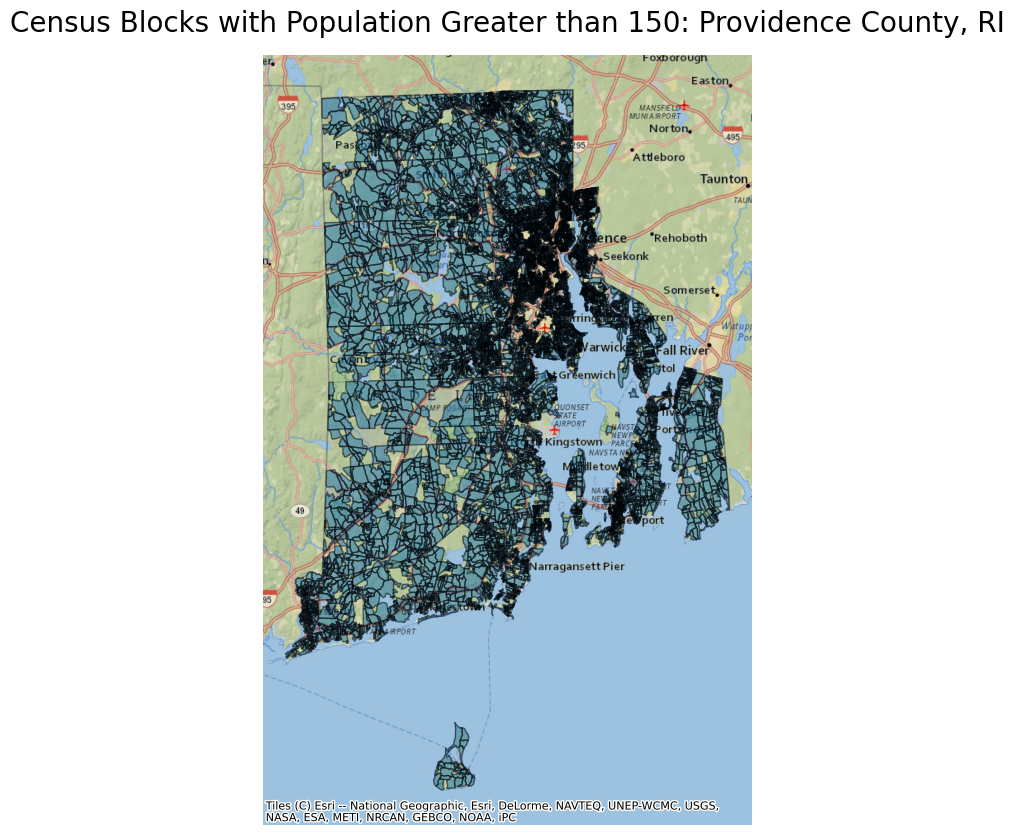

In [12]:
ax = ri.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax.set_title(
    "Census Blocks with Population Greater than 150: Providence County, RI",
    fontdict={"fontsize": "20", "fontweight": "2"},
)
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)
ax.set_axis_off()

Let's filter out the blocks with 0 reported population and plot the distribution of people per census block.

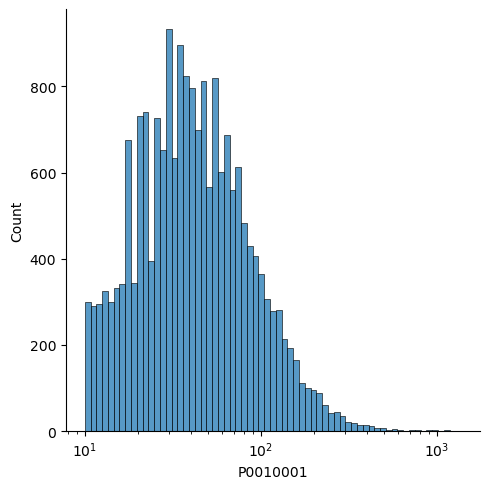

In [13]:
sns.displot(ri.P0010001, log_scale=True);

Or we can plot the relationship between the population and the size of the census block.

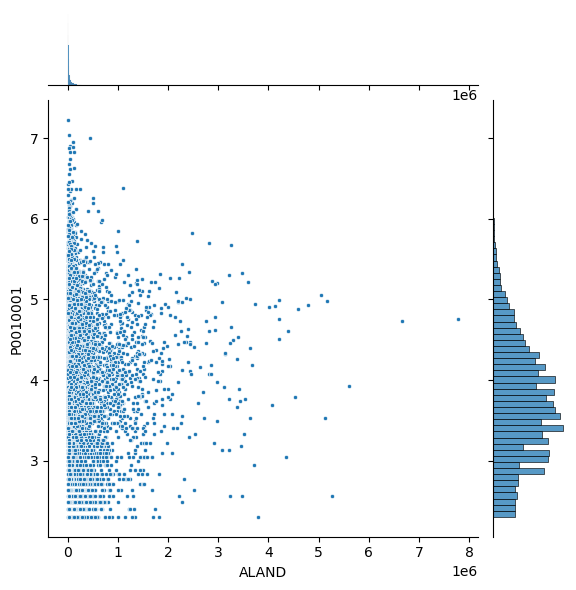

In [14]:
import numpy as np

sns.jointplot(x=ri.ALAND, y=np.log(ri.P0010001), marker=".");

### Next Steps

Now that you've seen an introduction to working with US Census data from the Planetary Computer, learn more with

* The [US Census data tutorial](../../tutorials/census-data.ipynb), which includes examples for accessing data at each level of cartographic aggregation available
* The [Reading tabular data quickstart](../../quickstarts/reading-tabular-data.ipynb), which introduces how to use tabular data with the Planetary Computer